# House Price Prediction with Random Forest Regression

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_data = open('/content/drive/MyDrive/dataset_INFO6105/house_dataset/train.csv')
test_data = open('/content/drive/MyDrive/dataset_INFO6105/house_dataset/test.csv')

In [4]:
df = pd.read_csv(train_data)
print(df.shape)

(1460, 81)


# Explore and clean data

In [5]:
# Peek at the dateset
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Find columns with missing values and their percent missing
df.isnull().sum()                                                     
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])

# Add a new column to the dataframe and fill it with the percentage of missing values
miss_val['Percent'] = miss_val.MissvalCount.apply(lambda x : '{:.2f}'.format(float(x)/df.shape[0] * 100)) 
miss_val = miss_val[miss_val.MissvalCount > 0]
miss_val

,MissvalCount,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


We'll remove those features with a high percent of missing values such as PoolQC, MiscFeature, Alley, Fence, and FireplaceQu. Note that the LotFrontage feature has only 16% missing. This is relatively low so we can choose to replace the NaN values with the imputed mean of the column. We will remove the remainder rows with missing values.  

In [9]:
# drop columns with high missing values
df = df.drop(['Fence', 'MiscFeature', 'PoolQC','FireplaceQu','Alley'], axis=1)

In [10]:
# drop rows with any missing values
df.dropna(inplace=True)

In [11]:
#df.info()

In [12]:
# Check the dimension of the dataset
df.shape

(1094, 76)

The dataset is cleaned. It now has 1094 observations and 76 features. 

# Explore data

Let's examine the data distributions of the features. We will start with the target variable, SalesPrice, to make sure it's normal distributed. This is important because most machine learning algorithms make the assumption that the data is normal distributed. When data fits a normal distribution, we can make statements about the population using analytical techniques. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


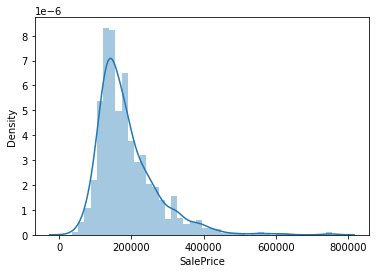

In [13]:
# Check distribution of target variable
sns.distplot(df.SalePrice)

We can see the SalePrice distribution is skewed to the right. Let's transform it so that it follows a gaussian normal distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


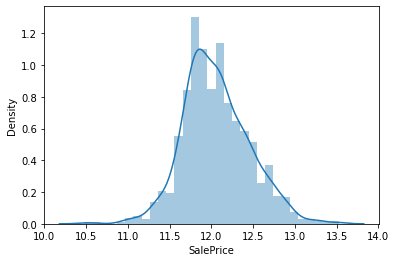

In [14]:
# Transform the target variable 
sns.distplot(np.log(df.SalePrice))

The data is now more normal distributed. We will use this transformed data in the dataframe and remove the skewed distribution:

In [15]:
df['LogOfPrice'] = np.log(df.SalePrice)
df.drop(["SalePrice"], axis=1, inplace=True)

Let's check the skewness of the input feature.

In [16]:
# Review the skewness of each feature
df.skew().sort_values(ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


LotArea          15.508309
PoolArea         13.614615
3SsnPorch        11.069793
LowQualFinSF      9.896145
MiscVal           9.673292
KitchenAbvGr      5.587741
BsmtFinSF2        4.372440
BsmtHalfBath      4.049639
ScreenPorch       3.962075
EnclosedPorch     3.165433
MasVnrArea        2.695262
OpenPorchSF       2.382985
TotalBsmtSF       2.314581
LotFrontage       2.227272
BsmtFinSF1        1.931425
GrLivArea         1.553875
WoodDeckSF        1.525006
MSSubClass        1.428836
1stFlrSF          1.371529
BsmtUnfSF         0.884701
OverallCond       0.862376
2ndFlrSF          0.790156
GarageArea        0.726787
TotRmsAbvGrd      0.721070
Fireplaces        0.629886
HalfBath          0.607079
BsmtFullBath      0.532962
LogOfPrice        0.304486
OverallQual       0.298295
GarageCars        0.210251
MoSold            0.168709
YrSold            0.122460
Id                0.020785
FullBath          0.019856
BedroomAbvGr      0.016689
YearRemodAdd     -0.585271
YearBuilt        -0.633765
G

Values closer to zero are less skewed. The results show some features having a positive (right-tailed) or negative (left-tailed) skew. We can see YearBuilt is slightly skewed to the left but pretty much normal distributed while LotArea and PoolArea are highly skewed to the right. Highly skewed distributions in the dataset may benefit from data transforms in some way to improve our prediction accuracy.

# Train-Test Split dataset

Before we can start modeling the data, we need to split the dataset into training and test sets. We will train the models with the training set and cross-validate with the test set. Recall we have lots of features in the dataset that are text. Most machine learning models require numerical input features. Since the process of converting text features to a numeric representation an involved task, we will only use the numeric features in our price prediction (for simplicity sake). 

In [17]:
# set the target and predictors
y = df.LogOfPrice  # target

# use only those input features with numeric data type 
df_temp = df.select_dtypes(include=["int64","float64"]) 
X = df_temp.drop(["LogOfPrice"],axis=1)  # predictors

To split the dataset, we will use random sampling with 75/25 train-test split; that is, we'll use 75% of the dataset for training and set aside 25% for testing:

In [18]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 3)

## Random Forest

In [19]:
#rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print("R2: ", rfr_cv.mean())

R2:  0.8607604474679986


Random forest is an advanced decision tree based machine learning. It has a classification and a regression random forest algorithm. Its performance is slightly better than regression. Like regularization, we can optimize the model parameters for best performance using gridsearch.

In [20]:
# Random forest determined feature importances
rfr.feature_importances_

array([6.54232159e-03, 3.61701507e-03, 1.28868130e-02, 1.85714548e-02,
       5.83404147e-01, 1.77853390e-02, 1.55159507e-02, 2.88912284e-02,
       2.98316255e-03, 1.84000034e-02, 4.24501366e-04, 6.78737433e-03,
       3.70843727e-02, 3.45425597e-02, 1.08233576e-02, 1.15610821e-05,
       8.29076192e-02, 1.09238017e-03, 3.70924549e-04, 6.87843536e-03,
       1.05080361e-03, 2.35735966e-03, 1.51102344e-03, 3.79624854e-03,
       4.61097022e-03, 8.04807778e-03, 4.56219801e-02, 1.83344687e-02,
       5.73059331e-03, 5.85504401e-03, 3.81362073e-03, 4.09526510e-04,
       7.07940125e-04, 1.27538409e-04, 8.46547705e-04, 4.99627712e-03,
       2.66145834e-03])

# Plotting the Feature Importance
Let's see the features that are the most promissing predictors:

In [21]:
importance = rfr.feature_importances_

# map feature importance values to the features
feature_importances = zip(importance, X.columns)
#list(feature_importances)

sorted_feature_importances = sorted(feature_importances, reverse = True)
#print(sorted_feature_importances)

top_15_predictors = sorted_feature_importances[0:15]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'LotArea', 'BsmtFinSF1', 'GarageArea', 'OverallCond', 'YearBuilt', 'LotFrontage', '2ndFlrSF', 'GarageYrBlt', 'FullBath']


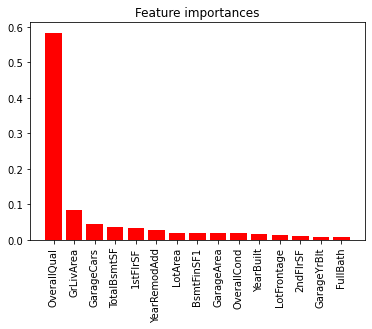

In [22]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

# Conclusion

Random Forest is the most accurate model for predicting the house price. It scored an estimated accuracy of 85%, out performing other regression models. Random Forest determined the overall quality of a home is by far the most important predictor.